In [436]:
from py_ball import playbyplay, boxscore, team
from nba_help import constants
import time
import numpy as np
import json
import os
from sklearn import linear_model

In [2]:
TOTAL_GAMES_PER_YEAR = 1230

In [477]:
def get_seconds_left(period, time_string, number_of_quarters):
    time_in_quarter = 12
    if period > 4:
        time_in_quarter=5
    mins, seconds = time_string.split(':')
    extra_after_quarter = (4-period)*time_in_quarter*60
    if period > 4:
        extra_after_quarter = (5-period)*time_in_quarter*60
        time_elapsed = (time_in_quarter*60) - ((int(mins)*60)+(int(seconds)))
        return extra_after_quarter-time_elapsed
    else:
        return extra_after_quarter+(int(mins)*60)+(int(seconds))



In [4]:
def get_game_ids(years):
    game_ids = []
    for year in years:
        for game in range(1, TOTAL_GAMES_PER_YEAR+1):
            maybe = '002%s' + str(game).zfill(5)
            game_ids.append(maybe % year)
    return game_ids

In [52]:
def populate_train_test(game_ids):
    train_x = []
    train_y = []
    for game_id in game_ids:
        print(game_id)
        
        pbp = playbyplay.PlayByPlay(headers=constants.headers, game_id=game_id)
        with open('/home/avyayv/data/nba/playbyplay/py_ball/'+game_id+'.json', 'w') as fp:
            json.dump(pbp.data, fp)
            
        time.sleep(0.5)
    return train_x, train_y

In [53]:
train_gids = get_game_ids(['15','16', '17'])

In [ ]:
populate_train_test(train_gids)

0021500001
0021500002
0021500003
0021500004
0021500005
0021500006
0021500007
0021500008
0021500009
0021500010
0021500011
0021500012
0021500013
0021500014
0021500015
0021500016
0021500017
0021500018
0021500019
0021500020
0021500021
0021500022
0021500023
0021500024
0021500025
0021500026
0021500027
0021500028
0021500029
0021500030
0021500031
0021500032
0021500033
0021500034
0021500035
0021500036
0021500037
0021500038
0021500039
0021500040
0021500041
0021500042
0021500043
0021500044
0021500045
0021500046
0021500047
0021500048
0021500049
0021500050
0021500051
0021500052
0021500053
0021500054
0021500055
0021500056
0021500057
0021500058
0021500059
0021500060
0021500061
0021500062
0021500063
0021500064
0021500065
0021500066
0021500067
0021500068
0021500069
0021500070
0021500071
0021500072
0021500073
0021500074
0021500075
0021500076
0021500077
0021500078
0021500079
0021500080
0021500081
0021500082
0021500083
0021500084
0021500085
0021500086
0021500087
0021500088
0021500089
0021500090
0021500091

0021500746
0021500747
0021500748
0021500749
0021500750
0021500751
0021500752
0021500753
0021500754
0021500755
0021500756
0021500757
0021500758
0021500759
0021500760
0021500761
0021500762
0021500763
0021500764
0021500765
0021500766
0021500767
0021500768
0021500769
0021500770
0021500771
0021500772
0021500773
0021500774
0021500775
0021500776
0021500777
0021500778
0021500779
0021500780
0021500781
0021500782
0021500783
0021500784
0021500785
0021500786
0021500787
0021500788
0021500789
0021500790
0021500791
0021500792
0021500793
0021500794
0021500795
0021500796
0021500797
0021500798
0021500799
0021500800
0021500801
0021500802
0021500803
0021500804
0021500805
0021500806
0021500807
0021500808
0021500809
0021500810
0021500811
0021500812
0021500813
0021500814
0021500815
0021500816
0021500817
0021500818
0021500819
0021500820
0021500821
0021500822
0021500823
0021500824
0021500825
0021500826
0021500827
0021500828
0021500829
0021500830
0021500831
0021500832
0021500833
0021500834
0021500835
0021500836

0021600261
0021600262
0021600263
0021600264
0021600265
0021600266
0021600267
0021600268
0021600269
0021600270
0021600271
0021600272
0021600273
0021600274
0021600275
0021600276
0021600277
0021600278
0021600279
0021600280
0021600281
0021600282
0021600283
0021600284
0021600285
0021600286
0021600287
0021600288
0021600289
0021600290
0021600291
0021600292
0021600293
0021600294
0021600295
0021600296
0021600297
0021600298
0021600299
0021600300
0021600301
0021600302
0021600303
0021600304
0021600305
0021600306
0021600307
0021600308
0021600309
0021600310
0021600311
0021600312
0021600313
0021600314
0021600315
0021600316
0021600317
0021600318
0021600319
0021600320
0021600321
0021600322
0021600323
0021600324
0021600325
0021600326
0021600327
0021600328
0021600329
0021600330
0021600331
0021600332
0021600333
0021600334
0021600335
0021600336
0021600337
0021600338
0021600339
0021600340
0021600341
0021600342
0021600343
0021600344
0021600345
0021600346
0021600347
0021600348
0021600349
0021600350
0021600351

0021601006
0021601007
0021601008
0021601009
0021601010
0021601011
0021601012
0021601013
0021601014
0021601015
0021601016
0021601017
0021601018
0021601019
0021601020
0021601021
0021601022
0021601023
0021601024
0021601025
0021601026
0021601027
0021601028
0021601029
0021601030
0021601031
0021601032
0021601033
0021601034
0021601035
0021601036
0021601037
0021601038
0021601039
0021601040
0021601041
0021601042
0021601043
0021601044
0021601045
0021601046
0021601047
0021601048
0021601049
0021601050
0021601051
0021601052
0021601053
0021601054
0021601055
0021601056
0021601057
0021601058
0021601059
0021601060
0021601061
0021601062
0021601063
0021601064
0021601065
0021601066
0021601067
0021601068
0021601069
0021601070
0021601071
0021601072
0021601073
0021601074
0021601075
0021601076
0021601077
0021601078
0021601079
0021601080
0021601081
0021601082
0021601083
0021601084
0021601085
0021601086
0021601087
0021601088
0021601089
0021601090
0021601091
0021601092
0021601093
0021601094
0021601095
0021601096

0021700521
0021700522
0021700523
0021700524
0021700525
0021700526
0021700527
0021700528
0021700529
0021700530
0021700531
0021700532
0021700533
0021700534
0021700535
0021700536
0021700537
0021700538
0021700539
0021700540
0021700541
0021700542
0021700543
0021700544
0021700545
0021700546
0021700547
0021700548
0021700549
0021700550
0021700551
0021700552
0021700553
0021700554
0021700555
0021700556
0021700557
0021700558
0021700559
0021700560
0021700561
0021700562
0021700563
0021700564
0021700565
0021700566
0021700567
0021700568
0021700569
0021700570
0021700571
0021700572
0021700573
0021700574
0021700575
0021700576
0021700577
0021700578
0021700579
0021700580
0021700581
0021700582
0021700583
0021700584
0021700585
0021700586
0021700587
0021700588
0021700589
0021700590
0021700591
0021700592
0021700593
0021700594
0021700595
0021700596
0021700597
0021700598
0021700599
0021700600
0021700601
0021700602
0021700603
0021700604
0021700605
0021700606
0021700607
0021700608
0021700609
0021700610
0021700611

In [478]:
def get_train_test_from_dir(directory='/home/avyayv/data/nba/playbyplay/py_ball/'):
    train_x = []
    train_y = []
    for file in os.listdir(directory):
        try:
            pbp = json.loads(open(directory+file).read())
            jump_event = pbp['PlayByPlay'][1]
            home_has_ball = (jump_event['HOMEDESCRIPTION'] != None)
            current_margin = 0
            home_wins = int(pbp['PlayByPlay'][-1]['SCOREMARGIN']) > 0
            last_second = 2880
            
            number_of_quarters = int(pbp['PlayByPlay'][-1]['PERIOD'])
            game_x = {}
            game_y = []
            
            added_this_game = []
            for event in pbp['PlayByPlay'][2:]:
                
                seconds_left_in_game = get_seconds_left(event['PERIOD'], event['PCTIMESTRING'], number_of_quarters)
                
                for sec in range(seconds_left_in_game+1, last_second):
                    if sec % 10 == 0 and (sec not in added_this_game):
                        game_x[sec] = [current_margin, home_wins, home_has_ball]
                        game_y.append(int(home_wins))
                        added_this_game.append(sec)
                    
                last_second = seconds_left_in_game
                
                home_desc = (event['HOMEDESCRIPTION'] != None)
                visitor_desc = (event['VISITORDESCRIPTION'] != None)
                
                if home_desc and not visitor_desc:
                    home_has_ball = True
                
                if visitor_desc and not home_desc:
                    home_has_ball = False
                    
                if home_desc and visitor_desc:
                    if ('STEAL' in event['HOMEDESCRIPTION']) or ('BLOCK' in event['HOMEDESCRIPTION']):
                        home_has_ball = True
                    else:
                        home_has_ball = False
                    
                if event['SCOREMARGIN'] != None:
                    margin = 0
                    if event['SCOREMARGIN'] != 'TIE':
                        margin = (int(event['SCOREMARGIN']))
                        current_margin = margin
                        
                if seconds_left_in_game % 10 == 0 and seconds_left_in_game not in added_this_game:  
                    game_x[seconds_left_in_game] = [current_margin, home_wins, home_has_ball]
                    game_y.append(int(home_wins))
                    added_this_game.append(int(seconds_left_in_game))
                
            train_x.append(game_x)
            train_y.append(game_y)
            
        except UnicodeDecodeError:
            continue
       
    return train_x, train_y


In [479]:
train_x, train_y = get_train_test_from_dir()

In [480]:
def train(train_x, train_y):
    time_to_train_x = {}
    time_to_train_y = {}
    time_to_model = {}
    for game in train_x:
        for key in game.keys():
            if key in time_to_train_x:
                time_to_train_x[key].append([game[key][0], game[key][2]])
                time_to_train_y[key].append(game[key][1])
            else:
                time_to_train_x[key] = [[game[key][0], game[key][2]]]
                time_to_train_y[key] = [game[key][1]]
                
    for key in time_to_train_x.keys():
        model = linear_model.LogisticRegression(max_iter=10000)
        model.fit(X=np.array(time_to_train_x[key]), y=np.array(time_to_train_y[key]))
        time_to_model[key] = model
    return time_to_model

In [481]:
time_to_model = train(train_x, train_y)

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/avyayv/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

In [383]:
import pickle

In [390]:
with open('model.pickle', 'wb') as handle:
    pickle.dump(time_to_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [247]:
%matplotlib inline
import matplotlib.pyplot as plt

In [482]:
def get_test(game_id):
    test_x = []
    test_y = []
    times = []
    diff = []
    pbp = playbyplay.PlayByPlay(headers=constants.headers, game_id=game_id).data
    bxscore = boxscore.BoxScore(headers=constants.headers, game_id=game_id, endpoint='boxscoresummaryv2').data
    team_abr = []
    game_summary = (bxscore['GameSummary'])[0]
    home_team_id = game_summary['HOME_TEAM_ID']
    visitor_team_id = game_summary['VISITOR_TEAM_ID']
    
    home_team_data = team.Team(headers=constants.headers, endpoint='teaminfocommon', team_id=home_team_id).data
    visitor_team_data = team.Team(headers=constants.headers, endpoint='teaminfocommon', team_id=visitor_team_id).data
    
    home = home_team_data['TeamInfoCommon'][0]['TEAM_ABBREVIATION']
    away = visitor_team_data['TeamInfoCommon'][0]['TEAM_ABBREVIATION']
        
    jump_event = pbp['PlayByPlay'][1]
    home_has_ball = (jump_event['HOMEDESCRIPTION'] != None)
    current_quarter = 1
    current_margin = 0
    home_wins = int(pbp['PlayByPlay'][-1]['SCOREMARGIN']) > 0
    last_second = 2880
    game_x = {}
    game_y = []
    added_this_game = []
    actual_times = []        
    number_of_quarters = int(pbp['PlayByPlay'][-1]['PERIOD'])

        
            
    for event in pbp['PlayByPlay'][2:]:

        seconds_left_in_game = get_seconds_left(event['PERIOD'], event['PCTIMESTRING'], number_of_quarters)

        for sec in range(seconds_left_in_game+1, last_second):
            if sec % 10 == 0 and (sec not in added_this_game):
                game_x[sec] = [current_margin, home_wins, home_has_ball]
                game_y.append(int(home_wins))
                added_this_game.append(sec)

        last_second = seconds_left_in_game

        home_desc = (event['HOMEDESCRIPTION'] != None)
        visitor_desc = (event['VISITORDESCRIPTION'] != None)

        if home_desc and not visitor_desc:
            home_has_ball = True

        if visitor_desc and not home_desc:
            home_has_ball = False

        if home_desc and visitor_desc:
            if ('STEAL' in event['HOMEDESCRIPTION']) or ('BLOCK' in event['HOMEDESCRIPTION']):
                home_has_ball = True
            else:
                home_has_ball = False

        if event['SCOREMARGIN'] != None:
            margin = 0
            if event['SCOREMARGIN'] != 'TIE':
                margin = (int(event['SCOREMARGIN']))
                current_margin = margin

        if seconds_left_in_game % 10 == 0 and seconds_left_in_game not in added_this_game:  
            game_x[seconds_left_in_game] = [current_margin, home_wins, home_has_ball]
            game_y.append(int(home_wins))
            added_this_game.append(int(seconds_left_in_game))

        test_x = (game_x)
        times = (list(game_x.keys()))
        diff.append(current_margin)
        actual_times.append(seconds_left_in_game)
    return test_x, times, diff, actual_times, home, away
    

In [483]:
def plot_probs_for_test(game_id, model=time_to_model, plot_wp=True):
    print(game_id)
    test_x, times, diff, actual_times, home, away = get_test(game_id)
    times = np.insert(times, 0, 2880)
    probs = []
    for time in times[1:]:
        time_prob = model[time].predict_proba([[test_x[time][0], test_x[time][2]]])[0]
        probs.append(time_prob)
    
    probs = np.array(probs)
    
    probs_home = np.insert(probs[:,0], 0, 0.5)
    probs_away = np.insert(probs[:,1], 0, 0.5)
    
    end_lim = 2880-(len(probs_home)*10)
    
    if plot_wp:
        fig, ax = plt.subplots(1,2)
        ax[0].set_title("Point Differential")
        ax[0].plot(actual_times, diff)
        ax[0].set_xlim(2880, end_lim)
        ax[1].plot(times, probs_home, label=home)
        ax[1].plot(times, probs_away, label=away)
        ax[1].set_xlim(2880, end_lim)
        ax[1].set_ylim(0.0, 1.0)
        ax[1].set_title("Win Probability")
        plt.legend(loc='best')
        plt.show()
    
    return probs_home, probs_away, home, away

In [484]:
plt.rcParams["figure.figsize"] = (20,6)

0021400002
[2880 2870 2860 2840 2850 2830 2820 2810 2790 2800 2770 2780 2750 2760
 2740 2720 2730 2710 2700 2690 2680 2660 2670 2650 2640 2610 2620 2630
 2600 2590 2580 2560 2570 2550 2540 2520 2530 2500 2510 2490 2470 2480
 2460 2450 2440 2430 2420 2410 2400 2380 2390 2370 2360 2350 2340 2320
 2330 2310 2300 2290 2280 2270 2260 2240 2250 2230 2210 2220 2190 2200
 2180 2170 2160 2150 2140 2130 2110 2120 2090 2100 2070 2080 2050 2060
 2040 2030 2020 2000 2010 1990 1980 1970 1960 1950 1940 1920 1930 1910
 1890 1900 1880 1870 1850 1860 1830 1840 1820 1810 1800 1790 1780 1770
 1760 1740 1750 1730 1710 1720 1690 1700 1670 1680 1660 1640 1650 1630
 1610 1620 1600 1590 1580 1570 1560 1540 1550 1520 1530 1510 1500 1480
 1490 1460 1470 1450 1440 1430 1420 1410 1400 1390 1380 1370 1340 1350
 1360 1330 1320 1300 1310 1290 1280 1270 1260 1250 1240 1230 1220 1210
 1200 1190 1180 1170 1160 1150 1140 1120 1130 1110 1090 1100 1080 1070
 1050 1060 1030 1040 1020 1010 1000  980  990  960  970  950  940 

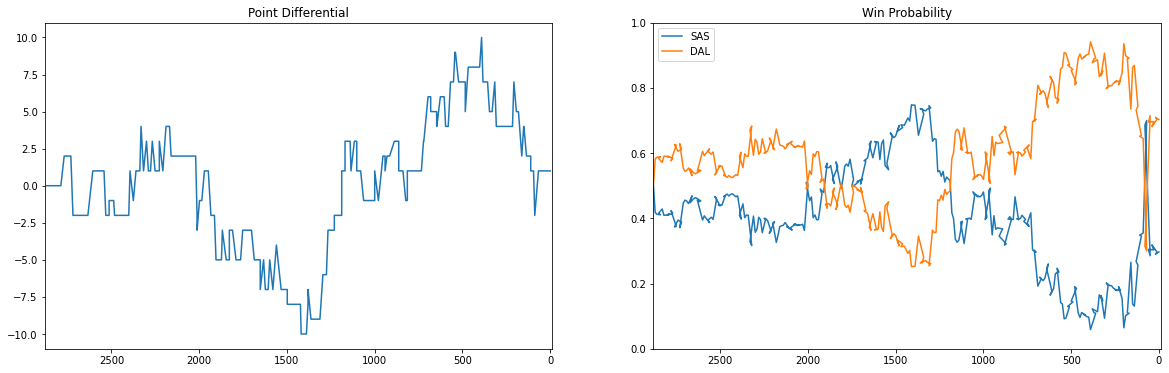

In [487]:
probs_home, probs_away, home, away = plot_probs_for_test(get_game_ids(['14'])[1], plot_wp=True)